In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

                 Close        MA50       MA200  signal  position
Date                                                            
2025-10-27  191.490005  179.807440  146.819711       0         1
2025-10-28  201.029999  180.188045  147.145459       0         1
2025-10-29  207.039993  180.816243  147.514654       0         1
2025-10-30  202.889999  181.366241  147.870448       0         1
2025-10-31  202.490005  181.916638  148.201846       0         1
2025-11-03  206.880005  182.494639  148.568542       0         1
2025-11-04  198.690002  182.872442  148.873592       0         1
2025-11-05  195.210007  183.141447  149.145645       0         1
2025-11-06  188.080002  183.271252  149.350855       0         1
2025-11-07  188.149994  183.431055  149.555665       0         1
2025-11-10  199.050003  183.928652  149.837971       0         1
2025-11-11  193.160004  184.376444  150.211800       0         1
2025-11-12  193.800003  184.840237  150.535990       0         1
2025-11-13  186.860001  1

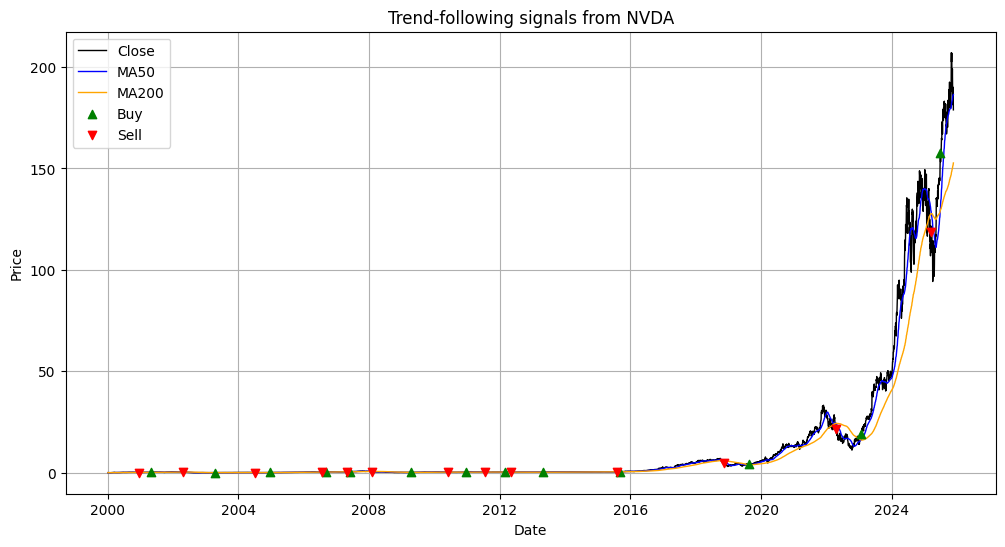

In [2]:
# path to the sqlite file
db_path = "data/processed/NVDA_proc.sqlite"

# connect and discover table name (pick a table containing 'nvda' if present, else first table)
conn = sqlite3.connect(db_path)
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
if tables.empty:
    conn.close()
    raise RuntimeError(f"No tables found in {db_path}")

table_names = tables['name'].astype(str).tolist()
table = next((t for t in table_names if 'nvda' in t.lower()), table_names[0])

# load the table
df = pd.read_sql_query(f'SELECT * FROM "{table}"', conn)
conn.close()

# --- Cleanup common issues: header-rows embedded in data & non-numeric strings ---

# If the first row contains values that match column names (a repeated header) or contains 'ticker', drop it.
try:
    first_row_vals = df.iloc[0].astype(str).str.lower().tolist()
    cols_lower = [c.lower() for c in df.columns]
    if any(v in cols_lower for v in first_row_vals) or any('ticker' in v for v in first_row_vals):
        df = df.iloc[1:].reset_index(drop=True)
except Exception:
    # if something odd with indexing, continue and rely on later coercion
    pass

# Try to convert obvious numeric columns to numeric (coerce errors -> NaN)
for col in df.columns:
    if col.lower() not in ('date', 'datetime', 'time', 'timestamp', 'index'):
        df[col] = pd.to_numeric(df[col], errors='coerce')

# try to identify a date column and set it as index
date_cols = [c for c in df.columns if c.lower() in ('date', 'datetime', 'time', 'timestamp', 'index')]
if date_cols:
    date_col = date_cols[0]
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col]).set_index(date_col)
else:
    # if no obvious date column, assume the first column is a datetime-like index if possible
    # attempt to parse the first column; if successful, set as index and drop it from columns
    try:
        possible_dates = pd.to_datetime(df.iloc[:, 0], errors='coerce')
        if possible_dates.notna().sum() > 0:
            df.index = possible_dates
            df = df.iloc[:, 1:]
    except Exception:
        # keep as-is
        pass

# If index is not a datetime index, try to infer index from a column named like the first column
if not isinstance(df.index, pd.DatetimeIndex):
    try:
        df.index = pd.to_datetime(df.index, errors='coerce')
    except Exception:
        pass

# drop rows without a valid datetime index (if index is datetime)
if isinstance(df.index, pd.DatetimeIndex):
    df = df[~df.index.isna()]

# ensure data sorted by index (time) if possible
try:
    df = df.sort_index()
except Exception:
    pass

# ensure we have a Close price column
close_col_candidates = [c for c in df.columns if c.lower() in ('close', 'adj_close', 'close_price', 'closepx')]
if not close_col_candidates:
    raise RuntimeError("No 'Close' column found in the table. Columns: " + ", ".join(df.columns))
close_col = close_col_candidates[0]
df = df.rename(columns={close_col: 'Close'})

# At this point ensure 'Close' is numeric
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# drop rows where Close is NaN (these are non-data rows)
df = df.dropna(subset=['Close'])

# compute moving averages (now on numeric data)
df['MA50'] = df['Close'].rolling(window=50, min_periods=1).mean()
df['MA200'] = df['Close'].rolling(window=200, min_periods=1).mean()

# generate crossover signals:
# buy (1) when MA50 crosses above MA200; sell (-1) when MA50 crosses below MA200; otherwise 0
diff = df['MA50'] - df['MA200']
df['signal'] = 0
buy_mask = (diff.shift(1) < 0) & (diff > 0)
sell_mask = (diff.shift(1) > 0) & (diff < 0)
df.loc[buy_mask, 'signal'] = 1
df.loc[sell_mask, 'signal'] = -1

# position: 1 when MA50 > MA200 (long), 0 otherwise
df['position'] = (df['MA50'] > df['MA200']).astype(int)

# optional: compute strategy returns (simple example, assumes entering/exiting at Close)
df['market_return'] = df['Close'].pct_change().fillna(0)
# shift position so that today's position reflects entry at close after signal (simple backtest assumption)
df['strategy_return'] = df['position'].shift(1).fillna(0) * df['market_return']
df['strategy_eq'] = (1 + df['strategy_return']).cumprod()

# show last rows with signals
print(df[['Close', 'MA50', 'MA200', 'signal', 'position']].tail(20))

# plot Close and MAs and mark buy/sell signals
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close', color='black', linewidth=1)
plt.plot(df.index, df['MA50'], label='MA50', color='blue', linewidth=1)
plt.plot(df.index, df['MA200'], label='MA200', color='orange', linewidth=1)

# plot buy/sell markers
buys = df[df['signal'] == 1]
sells = df[df['signal'] == -1]
plt.scatter(buys.index, buys['Close'], marker='^', color='green', label='Buy', zorder=5)
plt.scatter(sells.index, sells['Close'], marker='v', color='red', label='Sell', zorder=5)

plt.legend()
plt.title(f"Trend-following signals from {table}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [3]:
initial_capital = 1000.0

# Scenario 1: Buy and Hold (buy at start, hold till end)
first_price = float(df['Close'].iloc[0])
bh_shares = int(initial_capital // first_price)  # Whole shares
bh_cost = bh_shares * first_price
last_price = float(df['Close'].iloc[-1])
bh_final_value = bh_shares * last_price + (initial_capital - bh_cost)  # Any remaining cash
bh_return = (bh_final_value / initial_capital - 1) * 100 if initial_capital > 0 else 0

# Scenario 2: Follow Signals (all-in/all-out based on signals)
cash = float(initial_capital)
shares = 0
trade_records = []

for date, row in df.iterrows():
    sig = int(row.get('signal', 0))
    price = float(row['Close'])
    # Buy on buy signal if not already long
    if sig == 1 and shares == 0:
        buy_shares = int(cash // price)
        cost = buy_shares * price
        shares += buy_shares
        cash -= cost
        trade_records.append({'date': date, 'action': 'buy', 'price': price, 'shares': buy_shares, 'cash_after': cash})
    # Sell on sell signal if currently long
    elif sig == -1 and shares > 0:
        proceeds = shares * price
        cash += proceeds
        trade_records.append({'date': date, 'action': 'sell', 'price': price, 'shares': shares, 'proceeds': proceeds, 'cash_after': cash})
        shares = 0

# If still holding at the end, liquidate at last Close
if shares > 0:
    proceeds = shares * last_price
    cash += proceeds
    trade_records.append({'date': df.index[-1], 'action': 'liquidate', 'price': last_price, 'shares': shares, 'proceeds': proceeds, 'cash_after': cash})
    shares = 0

# Summarize signal scenario
signal_final_value = cash
signal_return = (signal_final_value / initial_capital - 1) * 100 if initial_capital > 0 else 0
trades_df = pd.DataFrame(trade_records)

# Print summaries
print("=== Scenario 1: Buy and Hold ===")
print(f"Initial capital: ${initial_capital:,.2f}")
print(f"Bought on {df.index[0].date()}: price ${first_price:.4f}, shares: {bh_shares}, cost: ${bh_cost:,.2f}")
print(f"Final value (at {df.index[-1].date()}): ${bh_final_value:,.2f}")
print(f"Total return: {bh_return:.2f}%")

print("\n=== Scenario 2: Follow Signals ===")
print(f"Initial capital: ${initial_capital:,.2f}")
print(f"Final value: ${signal_final_value:,.2f}")
print(f"Total return: {signal_return:.2f}%")
if not trades_df.empty:
    print("\nTrade log:")
    print(trades_df)
else:
    print("No trades occurred.")

=== Scenario 1: Buy and Hold ===
Initial capital: $1,000.00
Bought on 2000-01-03: price $0.0894, shares: 11183, cost: $999.99
Final value (at 2025-11-21): $2,000,415.11
Total return: 199941.51%

=== Scenario 2: Follow Signals ===
Initial capital: $1,000.00
Final value: $991,989.63
Total return: 99098.96%

Trade log:
         date     action       price  shares     cash_after       proceeds
0  2001-04-24        buy    0.292410    3419       0.248729            NaN
1  2002-04-24       sell    0.248171    3419     848.744008     848.495279
2  2003-04-10        buy    0.102386    8289       0.067707            NaN
3  2004-07-01       sell    0.149223    8289    1236.977770    1236.910063
4  2004-12-23        buy    0.176271    7017       0.082654            NaN
5  2006-07-20       sell    0.293556    7017    2059.968276    2059.885622
6  2006-09-12        buy    0.441175    4669       0.121859            NaN
7  2007-04-25       sell    0.505968    4669    2362.484941    2362.363082
8  2007